In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as tm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [14]:
train = pd.read_csv('train.csv')

In [15]:
train.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x757,x758,x759,x760,x761,x762,x763,x764,x765,y
0,0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,...,0.0007,297281012,0.13,5.0,5,2.0,8.5127,14.28,-0.75,5
1,1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,...,0.1136,3320000000000,0.08,661.0,0,350.0,1.5700,160.12,NaN,1
2,2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,...,0.0029,100474819,0.39,39.0,2,18.0,9.6800,25.06,-0.49,11
3,3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,...,0.0000,348000000000,0.25,2.0,1,0.0,4.5316,117.76,1.64,1
4,4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,...,0.0005,109546590,0.11,11.0,1,3.0,16.2717,5.81,-0.42,5


In [16]:
y = train.y
x = train.drop("y", axis=1)
x = x.drop("id", axis=1)

In [17]:
x = x.apply(pd.to_numeric, errors='coerce')

In [18]:
y.isnull().sum()

0

In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression

# Pearson correlation
corr_matrix = x.corrwith(y)
selected_corr_features = corr_matrix[corr_matrix.abs() > 0.1].index.tolist()

# Mutual information
mutual_info = mutual_info_regression(x.fillna(x.mean()), y)  # Handle missing values in x by filling with column mean
mutual_info_df = pd.DataFrame({'Feature': x.columns, 'Mutual_info': mutual_info})
top_mutual_info_features = mutual_info_df.nlargest(200, 'Mutual_info')['Feature'].tolist()

# Combine the selected features from both filter methods
selected_features = list(set(selected_corr_features + top_mutual_info_features))

# Filter the dataset to keep only the selected features
x_filtered = x[selected_features]

# Apply RFE with a linear regression estimator (you can replace this with any other estimator)
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=50)
rfe.fit(x_filtered.fillna(x_filtered.mean()), y)  # Handle missing values in x_filtered by filling with column mean

# Get the selected features from RFE
final_selected_features = np.array(x_filtered.columns)[rfe.support_]

# Filter the dataset to keep only the final selected features
x_final = x_filtered[final_selected_features]

In [20]:
# Mutual information
mutual_info = mutual_info_regression(x.fillna(x.mean()), y)  # Handle missing values in x by filling with column mean
mutual_info_df = pd.DataFrame({'Feature': x.columns, 'Mutual_info': mutual_info})
top_mutual_info_features = mutual_info_df.nlargest(200, 'Mutual_info')['Feature'].tolist()

# Filter the dataset to keep only the selected features
x_filtered = x[top_mutual_info_features]

# Apply RFE with a decision tree estimator
estimator = DecisionTreeRegressor()
rfe = RFE(estimator, n_features_to_select=50)
rfe.fit(x_filtered.fillna(x_filtered.mean()), y)  # Handle missing values in x_filtered by filling with column mean

# Get the selected features from RFE
final_selected_features = np.array(x_filtered.columns)[rfe.support_]

# Filter the dataset to keep only the final selected features
x_final = x_filtered[final_selected_features]

## Explanation for dropping predictors 

I completed this method by combining different methods of dropping predictors. I used some processes we didn't learn in class. I dropped 716 different predictors this way, which I assume is too many so I will go back and reprocess it. This, however, was incredibly helpful in creating my models as they only took a few minutes relative to a few hours that some other people were working with. Once I have a model I am comfortable with, I will add back in some predictors and see if it makes a difference. With this code alone and my models, I achieved a test RMSE of 9.29, which is currently placed at #16. 

This code works by: 
1. Calculating the mutual information between each predictor in the dataset x and the target variable y. Mutual information measures the dependency between the variables, with higher values indicating stronger dependency. Missing values in x are filled with the column mean, which could have been something else. For example, the median. 

2. Create a DataFrame mutual_info_df containing the feature names and their corresponding mutual information values.

3. Select the top 200 features with the highest mutual information values. These features are stored in the top_mutual_info_features list.

4. Filter the dataset x to keep only the selected features from the previous step, resulting in the x_filtered DataFrame.

5. Apply Recursive Feature Elimination (RFE) using a Decision Tree Regressor as the estimator. RFE is a wrapper method that recursively removes features based on their importance. The goal is to select the top 50 features.

6. Fit the RFE model on the filtered dataset x_filtered, handling missing values by filling them with the column mean.

7. Get the selected features from RFE using the support_ attribute, which returns a boolean mask indicating the selected features. The final_selected_features array contains the names of these selected features.

8. Filter the dataset x_filtered to keep only the final selected features, resulting in the x_final DataFrame.

In [21]:
x = x_final.copy()

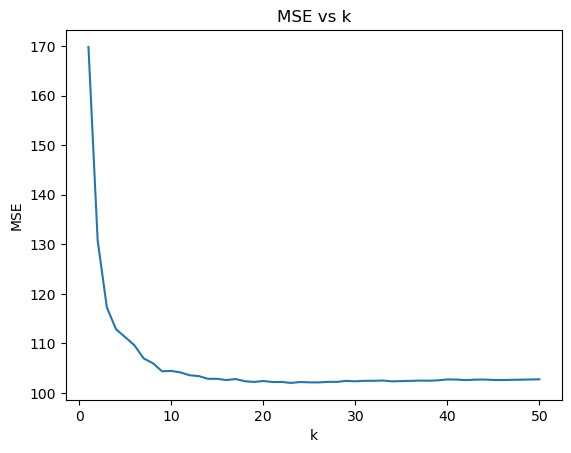

Optimal K: 23
MSE for optimal K: 102.02328653576537


In [23]:
# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

# Initialize a dictionary to store the weighted average MSE for each value of k
mse_dict = {}

# Iterate over the potential optimal values of the hyperparameter 'k' of the KNN algorithm
for k in range(1, 51):
    
    mse_list = []
    weights = []

    # Impute the missing values of X_scaled with the 'k' under consideration
    imputer = KNNImputer(n_neighbors=k)
    X_imputed_k = pd.DataFrame(imputer.fit_transform(X_scaled), columns=X_scaled.columns)
    
    # Iterate over each predictor in the data
    for predictor in X_scaled.columns:
        
        # If there are no missing values in 'predictor', skip the lines below, and continue with the next predictor
        if x[predictor].isna().sum() == 0:
            continue
        
        # Remove the observations from 'X_imputed_k', where the 'predictor' has actual missing values
        X_imputed_non_missing_k = X_imputed_k.loc[x[predictor].notna()]
        
        # Similarly, remove the observations that have missing values in 'predictor'
        predictor_nonmissing = y.loc[x[predictor].notna()]
        
        # Use cross_val_score to compute the 5-fold cross-validated MSE
        knn = KNeighborsRegressor(n_neighbors=k)
        mse = -cross_val_score(knn, X_imputed_non_missing_k, predictor_nonmissing, cv=5, scoring='neg_mean_squared_error')
        
        # Compute the weighted average of MSEs
        mse_list.append(np.mean(mse))
        weights.append(len(predictor_nonmissing))
    
    # Compute the weighted average of MSEs for tbhe current k value
    mse_whole_data_k = np.average(mse_list, weights=weights)
    mse_dict[k] = mse_whole_data_k
    
# Find the optimal k and the corresponding MSE
optimal_k = min(mse_dict, key=mse_dict.get)
mse_optimal_k = mse_dict[optimal_k]

# Plot MSE_whole_data_k vs k
plt.plot(list(mse_dict.keys()), list(mse_dict.values()))
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('MSE vs k')
plt.show()

# Report the optimal K, MSE_whole_data_K for the optimal K
print(f"Optimal K: {optimal_k}")
print(f"MSE for optimal K: {mse_optimal_k}")

## Explanation KNN
This code follows the skeleton code given. It works as such: 

1. Scale the input data x using StandardScaler so that all predictors are on the same scale. 
2. Initialize a dictionary mse_dict to store the weighted average MSE for each value of k. 
3. Iterate over each value of k and perform the following steps:
    a. Impute the missing values in the scaled dataset X_scaled using KNN imputation with the current k value.
    b. For each predictor in the dataset, perform the following steps:
        i. If there are no missing values in the predictor, skip to the next predictor.
        ii. Remove the observations with actual missing values in the predictor.
        iii. Calculate the 5-fold cross-validated MSE when the non-missing values in the predictor are predicted using KNN with the current k value.
        iv. Compute the weighted average of the MSEs, with the weights being the number of non-missing values in each predictor.
    c. Calculate the overall weighted average of MSEs for the current k value and store it in the mse_dict.
4. Find the optimal k value, which is the one with the lowest MSE.
5. Plot the MSE values against the k values to visualize the relationship between the two.
6. Print the optimal k value and its corresponding MSE.

In [24]:
imputer = KNNImputer(n_neighbors=optimal_k)
x_imputed = pd.DataFrame(imputer.fit_transform(X_scaled), columns=x.columns)

# Inverse transform to get the original scale of the data
x_imputed_original_scale = pd.DataFrame(scaler.inverse_transform(x_imputed), columns=x.columns)
x = x_imputed_original_scale.copy()

In [26]:
model = DecisionTreeRegressor(random_state=45) 
model.fit(x, y)

DecisionTreeRegressor(random_state=45)

In [27]:
print("Maximum tree depth =", model.get_depth())

print("Maximum leaves =", model.get_n_leaves())

Maximum tree depth = 33
Maximum leaves = 3284


In [28]:
parameters = {'max_depth':range(2,42, 3),'max_leaf_nodes':range(2,3700, 100), 'min_samples_leaf': range(1,20,2)}
cv = KFold(n_splits = 5,shuffle=True,random_state=45)
model = GridSearchCV(DecisionTreeRegressor(random_state=45), parameters, n_jobs=-1,verbose=1,cv=cv, scoring='neg_mean_squared_error')
model.fit(x, y)
print (model.best_score_, model.best_params_)

Fitting 5 folds for each of 5180 candidates, totalling 25900 fits
-118.06488173550147 {'max_depth': 8, 'max_leaf_nodes': 102, 'min_samples_leaf': 19}


In [29]:
parameters = {'max_depth':range(2, 8),'max_leaf_nodes':range(90, 110), 'min_samples_leaf': range(18, 22)}
cv = KFold(n_splits = 5,shuffle=True,random_state=45)
model = GridSearchCV(DecisionTreeRegressor(random_state=45), parameters, n_jobs=-1,verbose=1,cv=cv, scoring='neg_mean_squared_error')
model.fit(x, y)
print (model.best_score_, model.best_params_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
-116.93428322886277 {'max_depth': 7, 'max_leaf_nodes': 90, 'min_samples_leaf': 20}


In [35]:
n_samples = x.shape[0]
n_features = x.shape[1]

param_grid = {'n_estimators': [290, 300, 310],
              'max_features': [11, 12, 13],
              'max_depth': [25, 35, 45],
              'bootstrap': [True, False],
              'oob_score': [True, False]}

cv = KFold(n_splits=5, shuffle=True, random_state=4)
rf_grid = GridSearchCV(RandomForestRegressor(random_state=44, n_jobs=-1),
                       param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
rf_grid.fit(x, y)

best_params = rf_grid.best_params_
best_score = -rf_grid.best_score_

print(f"Best parameters: {best_params}")
print(f"Best negative mean absolute error: {best_score}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jackokeefe/miniconda3/envs/ten

Best parameters: {'bootstrap': True, 'max_depth': 45, 'max_features': 13, 'n_estimators': 300, 'oob_score': True}
Best negative mean absolute error: 92.084295165221


In [2]:
x = pd.read_csv('x.csv')

In [4]:
y = pd.read_csv('y.csv')

In [53]:
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score
import xgboost as xgb

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=41)

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': params['learning_rate'],
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': "{:.3f}".format(params['colsample_bytree']),
        'min_child_samples': int(params['min_child_samples']),
        'feature_fraction': "{:.3f}".format(params['feature_fraction']),
        'bagging_fraction': "{:.3f}".format(params['bagging_fraction'])
    }

    clf = xgb.XGBRegressor(
        n_estimators=500,  # increase number of trees
        **params
    )

    score = cross_val_score(clf, x, y, scoring='neg_mean_squared_error', cv=10, n_jobs=-1).mean()
    return -score

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 2, 12, 1),
    'gamma': hp.uniform('gamma', 0.1, 0.5),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.1, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, -1),
    'num_leaves': hp.quniform('num_leaves', 20, 250, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'min_child_samples': hp.quniform('min_child_samples', 100, 250, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.4, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, 1.0)
}

# Run the algorithm
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)  # increase number of evaluations

print(best)

 12%|██▌                  | 6/50 [02:08<15:01, 20.50s/trial, best loss: 88.31973392981993][23:20:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:20:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:20:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:20:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feat

[23:27:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:27:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:27:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:27:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:28:24] WARNING: /Use

 24%|████▊               | 12/50 [05:25<20:20, 32.12s/trial, best loss: 88.31973392981993][23:22:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:22:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:22:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:27:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feat

[23:19:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:19:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:19:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:19:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:20:00] WARNING: /Use

 26%|█████▏              | 13/50 [06:44<28:30, 46.24s/trial, best loss: 88.31973392981993][23:21:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:21:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:22:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[23:22:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feat

In [54]:
# Convert the params from 'best' to the correct format
best_params = {
    'max_depth': int(best['max_depth']),
    'gamma': float(best['gamma']),
    'subsample': float(best['subsample']),
    'reg_alpha': float(best['reg_alpha']),
    'reg_lambda': float(best['reg_lambda']),
    'learning_rate': float(best['learning_rate']),
    'num_leaves': int(best['num_leaves']),
    'min_child_samples': int(best['min_child_samples']),
    'feature_fraction': float(best['feature_fraction']),
    'bagging_fraction': float(best['bagging_fraction'])
}

# Instantiate and train the final model
final_model = xgb.XGBRegressor(n_estimators=200, **best_params)

# Fit the model to the training data
final_model.fit(x, y)

# Now you can use final_model to make predictions on unseen data
predictions = final_model.predict(X_test)

[23:47:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.



In [55]:
from sklearn.metrics import mean_squared_error

# Calculate the RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)

print("Root Mean Squared Error: ", rmse)

Root Mean Squared Error:  5.884690640589393


In [40]:
test = pd.read_csv('test.csv')

In [41]:
x_columns = x.columns.tolist()
selected_columns = x_columns + ['id']
test_selected = test[selected_columns]

In [42]:
test_x = test[x_columns]

In [43]:
model = RandomForestRegressor(n_estimators=290, random_state=48,n_jobs=-1,bootstrap=True,
                              max_features=12,max_depth=25, oob_score=True).fit(x, y)

/var/folders/xb/mpc8k2d54673jvhxz1y15twc0000gn/T/ipykernel_82153/2071581075.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  max_features=12,max_depth=25, oob_score=True).fit(x, y)


In [59]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

# Create the ensemble model
ensemble = VotingRegressor(estimators=[('rf', model), ('xgb', final_model)])

# Fit the ensemble model
ensemble.fit(X_train, y_train)

# Make predictions
predictions = ensemble.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE: ', rmse)

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[23:48:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

RMSE:  9.32708588858867


In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
test_x_scaled = pd.DataFrame(scaler.fit_transform(test_x), columns=test_x.columns)

In [62]:
imputer = KNNImputer(n_neighbors=23)
test_x_imputed = pd.DataFrame(imputer.fit_transform(test_x_scaled), columns=test_x.columns)

# Inverse transform to get the original scale of the data
test_x_imputed_original_scale = pd.DataFrame(scaler.inverse_transform(test_x_imputed), columns=test_x.columns)
test_x = test_x_imputed_original_scale.copy()

In [63]:
y_test = ensemble.predict(test_x)

In [64]:
result_df = pd.DataFrame({'id': test.id, 'y': y_test})
result_df.head()

,id,y
0,5380,4.634693
1,5381,8.353322
2,5382,3.196003
3,5383,7.412876
4,5384,7.493840


In [65]:
result_df.to_csv('result.csv', index=False)

In [ ]:
train.shape

In [8]:
x.shape

(5380, 765)